## Реализация обхода в ширину из нескольких стартовых вершин (Multiple-Source BFS)

In [306]:
import random
import graphblas as gb
from graphblas import Matrix
from graphblas import dtypes
from graphblas import monoid, semiring
from graphblas.io import mmread

In [63]:
edges = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1, 7],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 0],
]
max_index = max(max(edges[0]), max(edges[1]))
A = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]], nrows=max_index + 1, ncols=max_index + 1)
A

"M_3"      nvals  nrows  ncols  dtype         format
gb.Matrix     13      8      8   BOOL  bitmapr (iso)
----------------------------------------------------
      0     1     2     3     4     5     6 7
0        True        True                    
1                          True        True  
2                                True        
3  True        True                          
4                                True        
5              True                          
6              True  True  True              
7  True

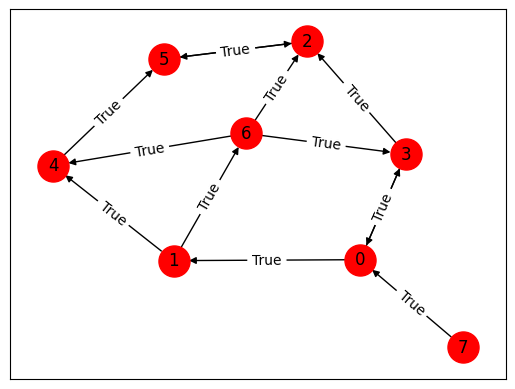

In [47]:
gb.viz.draw(A)

In [291]:
def MSBFS_levels(A, s):
    n = A.nrows
    m = len(s)
    levels = Matrix(dtypes.INT32, nrows=m, ncols=n)
    wavefront = Matrix(dtypes.BOOL, nrows=m, ncols=n)
    wavefront.build(list(range(m)), s, [True] * m)
    level = 0
    for _ in range(n):
        levels(mask=wavefront.V) << level
        level += 1
        wavefront(~levels.S, replace=True) << wavefront.mxm(A, semiring.lor_land)        
    levels(~levels.S) << -1
    rows, cols, values = levels.to_coo()
    result = []
    for i in range(levels.nrows):
        row_data = [(col, val) for r, col, val in zip(rows, cols, values) if r == i]
        result.append((i, row_data))
    return result

MSBFS_levels(A, [0,1])

[(0, [(0, 0), (1, 1), (2, 2), (3, 1), (4, 2), (5, 3), (6, 2), (7, -1)]),
 (1, [(0, 3), (1, 0), (2, 2), (3, 2), (4, 1), (5, 2), (6, 1), (7, -1)])]

Функция вернула массив пар: стартовая вершина и массив, где для каждой вершины указан уровень достижимости из этой стартовой. Стартовая вершина достижима на нулевом уровне, для недостижимой вершины уровень равен -1.

In [294]:
def MSBFS_parents(A, s):
    n = A.nrows
    m = len(s)
    idx, wavefront, parents = [Matrix(dtypes.INT32, nrows=m, ncols=n) for _ in range(3)]
    wavefront.build(list(range(m)), s, [n + 1 if v == 0 else v for v in s])
    parents.build(list(range(m)), s, [-1] * m)
    for i in range(m):
        for j in range(n):
            idx[i,j] = j
    for _ in range(n):
        wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.min_first)
        parents(mask=wavefront.V) << wavefront
        parents(mask=(parents == n + 1)) << 0
        wavefront(mask=wavefront.V) << idx
    parents(~parents.S) << -2
    rows, cols, values = parents.to_coo()
    result = []
    for i in range(parents.nrows):
        row_data = [(col, val) for r, col, val in zip(rows, cols, values) if r == i]
        result.append((i, row_data))
    return result

MSBFS_parents(A, [0,1])

[(0, [(0, -1), (1, 0), (2, 3), (3, 0), (4, 1), (5, 2), (6, 1), (7, -2)]),
 (1, [(0, 3), (1, -1), (2, 6), (3, 6), (4, 1), (5, 4), (6, 1), (7, -2)])]

Функция вернула массив пар: стартовая вершина и массив, где для каждой вершины графа указано, из какой вершины можно прийти в эту по кратчайшему пути из стартовой. Для стартовой значение -1, для недостижимой -2.

In [266]:
def test(A, s):
    result_MSBFS_levels = MSBFS_levels(A, s)
    result_MSBFS_parents = MSBFS_parents(A, s)
    
    if result_MSBFS_levels.ncols != A.nrows or result_MSBFS_parents.ncols != A.nrows \
                                            or result_MSBFS_levels.nrows != len(s) or result_MSBFS_parents.nrows != len(s):
        raise ValueError("Не все вершины просмотрены")

    for i in range(len(s)):
        if not (result_MSBFS_levels[i,:] == 0).reduce(monoid.lor, allow_empty=True).value:
            raise ValueError("Отсутствует стартовая вершина")

    for i in range(len(s)):
        if not (result_MSBFS_parents[i,:] == -1).reduce(monoid.lor, allow_empty=True).value:
            raise ValueError("Отсутствует стартовая вершина")

test(A, [0,1])

In [271]:
M1 = mmread('matrices/G37.mtx')
M2 = mmread('matrices/barth.mtx')
M3 = mmread('matrices/can_1072.mtx')
M4 = mmread('matrices/delaunay_n11.mtx')
M5 = mmread('matrices/struct4.mtx')
M6 = mmread('matrices/lshp1882.mtx')
M7 = mmread('matrices/nasa4704.mtx')
M8 = mmread('matrices/ukerbe1.mtx')
M9 = mmread('matrices/rajat02.mtx')
M10 = mmread('matrices/commanche_dual.mtx')

matrices = [M1, M2, M3, M4, M5, M6, M7, M8, M9, M10]

In [272]:
M4

"M_509"    nvals  nrows  ncols  dtype     format
gb.Matrix  12254   2048   2048   FP64  csr (iso)
------------------------------------------------
     0    1    2    3    4    5    6    7    8    9     ... 2038 2039 2040  \
0                                                       ...                  
1                                             1.0       ...                  
2                                                       ...                  
3                                                       ...                  
4                                                       ...                  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2043                                                    ...                  
2044                                                    ...                  
2045                                                    ...                  
2046                                                    ...                  
2047                                                    ...            1.0   

     2041 2042 2043 2044 2045 2046 2047  
0                                        
1                                        
2                                        
3                                        
4                                        
...   ...  ...  ...  ...  ...  ...  ...  
2043  1.0  1.0       1.0                 
2044       1.0  1.0                      
2045                                     
2046                                1.0  
2047  1.0                      1.0

In [274]:
def algorithm_running_time(matrices, s):
    i = 1
    for matrix in matrices:
        print('Матрица №', i)
        print('MSBFS levels:', end=' ')
        %timeit MSBFS_levels(matrix, s)
        print('MSBFS parents:', end=' ')
        %timeit MSBFS_parents(matrix, s)
        print()
        i += 1

algorithm_running_time(matrices, [1])

Матрица № 1
MSBFS levels: 267 ms ± 46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS parents: 1.24 s ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Матрица № 2
MSBFS levels: 758 ms ± 8.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS parents: 6.53 s ± 192 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Матрица № 3
MSBFS levels: 123 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
MSBFS parents: 551 ms ± 6.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Матрица № 4
MSBFS levels: 237 ms ± 6.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS parents: 1.02 s ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Матрица № 5
MSBFS levels: 493 ms ± 5.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS parents: 2.52 s ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Матрица № 6
MSBFS levels: 224 ms ± 7.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS parents: 1.17 

In [275]:
algorithm_running_time(matrices, [0, 1, 2, 3])

Матрица № 1
MSBFS levels: 259 ms ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS parents: 2.28 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Матрица № 2
MSBFS levels: 818 ms ± 42.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS parents: 10.9 s ± 898 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Матрица № 3
MSBFS levels: 124 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
MSBFS parents: 786 ms ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Матрица № 4
MSBFS levels: 236 ms ± 5.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS parents: 1.9 s ± 28.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Матрица № 5
MSBFS levels: 497 ms ± 9.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS parents: 3.47 s ± 45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Матрица № 6
MSBFS levels: 226 ms ± 7.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS parents: 2.18

MSBFS parents работает сильно дольше, чем MSBFS levels. При увеличении количества стартовых вершин время работы первого алгоритма (levels) не меняется, а для второго растёт.

In [305]:
def generate_random_undirected_graph(num_vertices, sparsity):

    graph = Matrix(dtypes.INT32, num_vertices, num_vertices)

    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if random.random() < sparsity:
                graph[i, j] = 1.0
                graph[j, i] = 1.0

    return graph

In [281]:
def generate_graphs(node_probs_list):
    return [generate_random_undirected_graph(nodes, prob) for nodes, prob in node_probs_list]

graph_specs = [
    (30, 0.1),
    (30, 0.2),
    (30, 0.3),
    (30, 0.4),
    (30, 0.5),
    (30, 0.6),
    (30, 0.7),
    (30, 0.8),
    (30, 0.9)
]

matrices = generate_graphs(graph_specs)

In [282]:
algorithm_running_time(matrices, [0, 1])

Матрица № 1
MSBFS levels: 4.77 ms ± 505 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
MSBFS parents: 17.3 ms ± 753 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Матрица № 2
MSBFS levels: 4.6 ms ± 582 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
MSBFS parents: 16 ms ± 569 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Матрица № 3
MSBFS levels: 3.99 ms ± 87.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
MSBFS parents: 17.9 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

Матрица № 4
MSBFS levels: 4.44 ms ± 493 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
MSBFS parents: 17.9 ms ± 644 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Матрица № 5
MSBFS levels: 4.23 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
MSBFS parents: 18.4 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

Матрица № 6
MSBFS levels: 4.02 ms ± 114 µs per loop (mean ± std. dev. of 7 runs,

Влияние степени разреженности графа на время работы обоих алгоритмов не заметно.

In [283]:
graph_specs = [
    (5, 0.5),
    (30, 0.5),
    (100, 0.5),
    (500, 0.5),
    (1000, 0.5),
    (2500, 0.5)
]

matrices = generate_graphs(graph_specs)

In [284]:
algorithm_running_time(matrices, [0, 1])

Матрица № 1
MSBFS levels: 912 µs ± 31.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
MSBFS parents: 3.4 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Матрица № 2
MSBFS levels: 4.22 ms ± 468 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
MSBFS parents: 17.4 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

Матрица № 3
MSBFS levels: 11.9 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
MSBFS parents: 52.1 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Матрица № 4
MSBFS levels: 58.1 ms ± 928 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
MSBFS parents: 447 ms ± 17.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Матрица № 5
MSBFS levels: 115 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
MSBFS parents: 1.82 s ± 25.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Матрица № 6
MSBFS levels: 285 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 1 loo

С увеличением размера графа растет и время работы алгоритмов.

Добавим в реализацию возможность использовать другие полукольца (```any.pair``` для ```levels``` и ```any.first``` для ```parents```)

In [301]:
def MSBFS_levels(A, s, semiring):
    n = A.nrows
    m = len(s)
    levels = Matrix(dtypes.INT32, nrows=m, ncols=n)
    wavefront = Matrix(dtypes.BOOL, nrows=m, ncols=n)
    wavefront.build(list(range(m)), s, [True] * m)
    level = 0
    for _ in range(n):
        levels(mask=wavefront.V) << level
        level += 1
        wavefront(~levels.S, replace=True) << wavefront.mxm(A, semiring)        
    levels(~levels.S) << -1
    rows, cols, values = levels.to_coo()
    result = []
    for i in range(levels.nrows):
        row_data = [(col, val) for r, col, val in zip(rows, cols, values) if r == i]
        result.append((i, row_data))
    return result

MSBFS_levels(A, [0,1], semiring.any_pair)

[(0, [(0, 0), (1, 1), (2, 2), (3, 1), (4, 2), (5, 3), (6, 2), (7, -1)]),
 (1, [(0, 3), (1, 0), (2, 2), (3, 2), (4, 1), (5, 2), (6, 1), (7, -1)])]

In [302]:
def MSBFS_parents(A, s, semiring):
    n = A.nrows
    m = len(s)
    idx, wavefront, parents = [Matrix(dtypes.INT32, nrows=m, ncols=n) for _ in range(3)]
    wavefront.build(list(range(m)), s, [n + 1 if v == 0 else v for v in s])
    parents.build(list(range(m)), s, [-1] * m)
    for i in range(m):
        for j in range(n):
            idx[i,j] = j
    for _ in range(n):
        wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring)
        parents(mask=wavefront.V) << wavefront
        parents(mask=(parents == n + 1)) << 0
        wavefront(mask=wavefront.V) << idx
    parents(~parents.S) << -2
    rows, cols, values = parents.to_coo()
    result = []
    for i in range(parents.nrows):
        row_data = [(col, val) for r, col, val in zip(rows, cols, values) if r == i]
        result.append((i, row_data))
    return result

MSBFS_parents(A, [0,1], semiring.any_first)

[(0, [(0, -1), (1, 0), (2, 3), (3, 0), (4, 1), (5, 4), (6, 1), (7, -2)]),
 (1, [(0, 3), (1, -1), (2, 6), (3, 6), (4, 1), (5, 4), (6, 1), (7, -2)])]

In [303]:
def algorithm_running_time_comparison_semiring(matrices, s):
    i = 1
    for matrix in matrices:
        print('MSBFS levels')
        print(' Матрица №', i)
        print('  lor.land:', end=' ')
        %timeit MSBFS_levels(matrix, s, semiring.lor_land)
        print('  any.pair:', end=' ')
        %timeit MSBFS_levels(matrix, s, semiring.any_pair)
        print()
        i += 1

    i = 1
    for matrix in matrices:
        print('MSBFS parents')
        print(' Матрица №', i)
        print('  min.first:', end=' ')
        %timeit MSBFS_parents(matrix, s, semiring.min_first)
        print('  any.first:', end=' ')
        %timeit MSBFS_parents(matrix, s, semiring.any_first)
        print()
        i += 1

In [296]:
graph_specs = [
    (5, 0.5),
    (15, 0.5),
    (30, 0.5),
    (100, 0.5),
    (500, 0.5),
    (750, 0.5),
    (1000, 0.5),
    (2500, 0.5)
]

matrices = generate_graphs(graph_specs)

In [304]:
algorithm_running_time_comparison_semiring(matrices, [0,1])

MSBFS levels
 Матрица № 1
  lor.land: 1.28 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
  any.pair: 1.34 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

MSBFS levels
 Матрица № 2
  lor.land: 2.74 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
  any.pair: 2.45 ms ± 32.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

MSBFS levels
 Матрица № 3
  lor.land: 5.32 ms ± 502 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
  any.pair: 4.7 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

MSBFS levels
 Матрица № 4
  lor.land: 15.3 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
  any.pair: 14.7 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

MSBFS levels
 Матрица № 5
  lor.land: 71.2 ms ± 4.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
  any.pair: 73 ms ± 6.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

MSBFS levels
 Матрица № 6
  lor

Использование полуколец lor.land или any.pair не показывает влияние на время работы MSBFS levels. На некоторых матрицах использование any.first вместо min.first в MSBFS parents сильно уменьшило время работы алгоритма.